# Generalized Additive Model

In [150]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from pygam import PoissonGAM, GammaGAM, f, s, te
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Static data
counties, counties_date = load_counties()

In [46]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, ma_width=7, time_series=False)

In [221]:
ddf = deaths_df.copy()
ddf = ddf.merge(counties[counties.columns.difference(ddf.columns).to_list() + ['FIPS']], on='FIPS')

## Normalized Mobility
ddf['OD_at_onset_normalized'] = ddf['OD_at_onset'] / ddf['OD_baseline']
ddf['OD_2wk_before_onset_normalized'] = ddf['OD_2wk_before_onset'] / ddf['OD_baseline']
ddf['OD_2wk_after_onset_normalized'] = ddf['OD_2wk_after_onset'] / ddf['OD_baseline']

## Black, african, hispanic, native american population
ddf['BAHN'] = ddf[['H_FEMALE', 'H_MALE', 'BA_FEMALE', 'BA_MALE', 'IA_MALE', 'IA_FEMALE']].sum(axis=1)

## Normalize others
log_vars = [
    'cum_deaths',
    'OD_baseline',
    'POP_ESTIMATE_2018',
    'Density per square mile of land area - Population',
    'Density per square mile of land area - Housing units',
]
## Compensate for 0 being a possible value
ddf[[l + ' (log)' for l in log_vars]] = ddf[log_vars].transform('log')

pop_vars = [
    'cum_deaths',
    'Beds',
    'HospCt',
    'Total_age65plus',
    'POVALL_2018',
    'BAHN',
]
ddf[[l + '_normalized' for l in pop_vars]] = ddf[pop_vars].div(ddf['POP_ESTIMATE_2018'], axis=0)

### Stratify and make X,y

In [222]:
RUCC = 3
ddf = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

In [223]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_2wk_before_onset_normalized',# s,
    'Density per square mile of land area - Population (log)',# s,
    'Density per square mile of land area - Housing units (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    #'Mar Temp AVG / F',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'cum_deaths_normalized'

X = ddf[predictor_vars].values
y = ddf[target_var].values

In [224]:
ddf[predictor_vars].head()

,onset_relative,OD_baseline (log),OD_at_onset_normalized,OD_2wk_before_onset_normalized,Density per square mile of land area - Population (log),Density per square mile of land area - Housing units (log),POP_ESTIMATE_2018 (log),Beds_normalized,HospCt_normalized,Total_age65plus_normalized,POVALL_2018_normalized,BAHN_normalized
0,53,12.880854,0.832593,0.786540,4.750136,4.197202,12.292356,0.001523,0.000014,0.204433,0.096637,0.143596
1,53,12.361350,0.842387,0.791211,5.281680,4.488636,11.646389,0.004830,0.000026,0.177175,0.190056,0.255861
3,36,12.242934,0.808305,0.801270,5.279135,4.496471,11.537638,0.006117,0.000020,0.190115,0.170818,0.203257
5,34,12.636344,0.704420,0.683772,5.445875,4.641502,12.007268,0.001915,0.000006,0.118829,0.183450,0.272214
13,29,12.418620,0.697788,0.753316,2.104134,1.481605,11.869585,0.002156,0.000021,0.124988,0.146751,0.433254


In [225]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [229]:
ggam = GammaGAM(s(0)+ # 'onset_relative'
                s(1)+#, constraints='monotonic_inc')+ # 'OD_baseline (log)'
                s(2)+#, constraints='monotonic_inc')+ # 'OD_at_onset_normalized'
                s(3)+#, constraints='monotonic_inc')+ # 'OD_2wk_before_onset_normalized'
                s(4)+#, constraints='monotonic_inc')+ # 'Density per square mile of land area - Population (log)'
                s(5)+#, constraints='monotonic_inc')+ # 'Density per square mile of land area - Housing units (log)'
                s(6)+ # 'POP_ESTIMATE_2018 (log)'
                s(7)+ # 'Beds_normalized'
                s(8)+ # 'HospCt_normalized'
                s(9)+ # 'Total_age65plus_normalized'
                s(10)+ # 'POVALL_2018_normalized'
                s(11))# 'BAHN_normalized'
#                  te(7,8)+ 
#                  te(10,11)+
#                  te(2,3)+
#                  te(4,5)
#                 , max_iter=200)

In [233]:
lams = np.random.rand(100, 12) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

In [234]:
ggam.gridsearch(X, y, lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + intercept,
   tol=0.0001, verbose=False)

In [235]:
ggam.summary()

GammaGAM                                                                                                  
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     14.8979
Link Function:                          LogLink Log Likelihood:                                   744.8876
Number of Samples:                           93 AIC:                                            -1457.9794
                                                AICc:                                           -1450.9194
                                                GCV:                                                0.7794
                                                Scale:                                               0.535
                                                Pseudo R-Squared:                                    0.303
Feature Function                  Lam

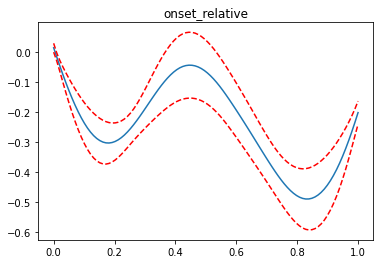

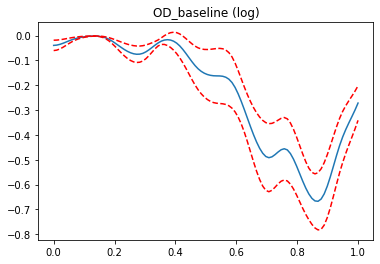

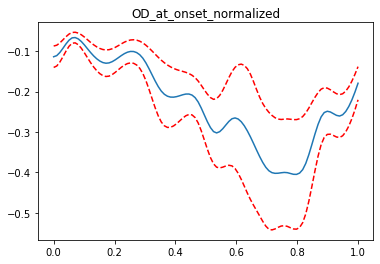

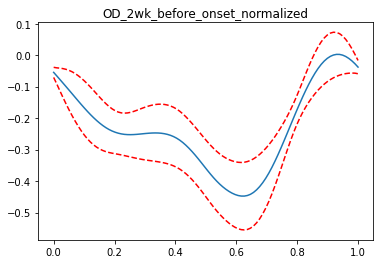

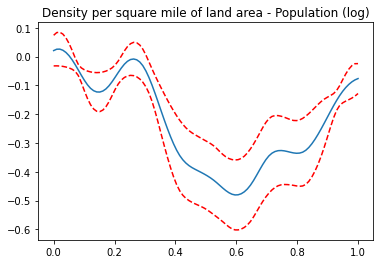

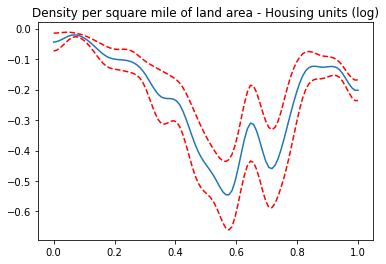

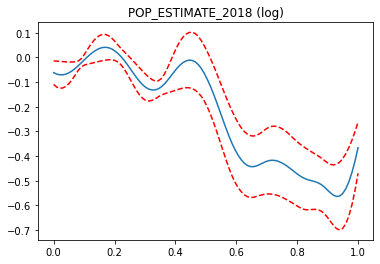

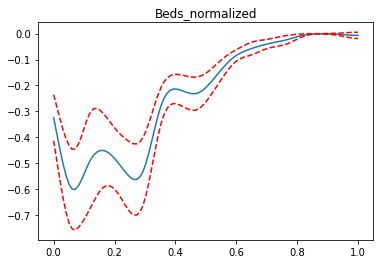

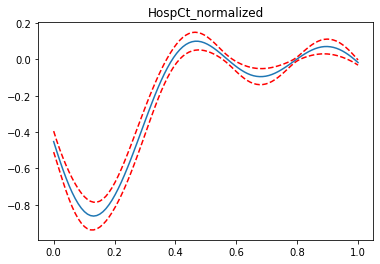

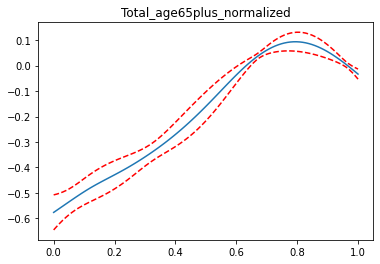

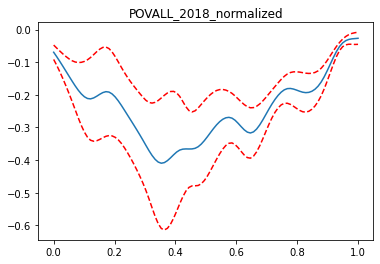

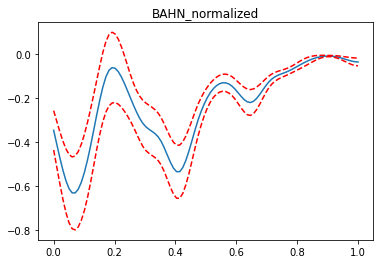

In [236]:
for i, term in enumerate(ggam.terms):
    if term.isintercept:
        continue

    XX = ggam.generate_X_grid(term=i)
    pdep, confi = ggam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax.plot(, np.zeros(x1.shape), 'b+', ms=20)
    plt.title(predictor_vars[i])
    plt.show()

In [ ]:
XX.shape